In [1]:
# this notebook is to create a custom dataset class and deep learning model with training loop to classify cats and dogs

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform

In [13]:
# create transform for data augmentation: normalize, and convert to tensor
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
size = 256
data_transforms = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean,std),transforms.CenterCrop(size)])

# get root directory and label mapping
data_dir = '/media/victoru/B612CEC512CE8A37/ai50/pytorch_test/data/cats_and_dogs_filtered'
label_dir = os.listdir(data_dir + '/train/')
idx_to_class = {i: j for i, j in enumerate(label_dir)}
class_to_idx = {value: key for key, value in idx_to_class.items()}

# define hyperparameters
batch_size = 10
num_epochs = 25

#show image
def imshow(inp):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.show()

In [3]:
print(label_dir)

['cats', 'dogs']


In [4]:
#create dataset class for cats and dogs

class catsdogsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # get root directory
        self.root_dir = root_dir
        # get transform
        self.transform = transform
        # get list of label from directory under root_dir
        self.label_dir = os.listdir(root_dir)
        self.data = pd.DataFrame(columns=['image_name', 'label'])
        tempdata = pd.DataFrame(columns=['image_name', 'label'])
        # loop through each label and store list of image name and corresponding label
        for label in self.label_dir:
            tempdata['image_name'] = os.listdir(os.path.join(root_dir, label))
            tempdata['label'] = label
            self.data = pd.concat([self.data, tempdata],ignore_index = True, axis = 0)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,self.data.iloc[idx, 1],self.data.iloc[idx, 0])
        image = io.imread(img_name)
        label = torch.tensor(class_to_idx[self.data.iloc[idx, 1]])
                
        if self.transform:
            image = self.transform(image)
            
        return image,label

In [5]:
# send device to gpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [14]:
train_dataset = catsdogsDataset(root_dir='/media/victoru/B612CEC512CE8A37/ai50/pytorch_test/data/cats_and_dogs_filtered/train', transform=data_transforms)
test_dataset = catsdogsDataset(root_dir='/media/victoru/B612CEC512CE8A37/ai50/pytorch_test/data/cats_and_dogs_filtered/validation', transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
len(train_dataset)

2000

torch.Size([10, 3, 256, 256])
<class 'torch.Tensor'>
tensor([1, 1, 0, 0, 0, 1, 0, 0, 0, 0])


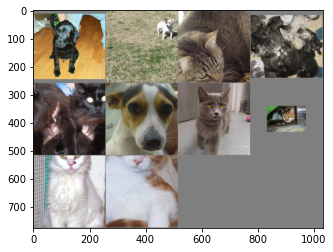

In [15]:
for i, (images,labels) in enumerate(train_loader):
    print(images.shape)
    print(type(images))
    print(labels)
    imshow(utils.make_grid(images, nrow=4))
    break


In [10]:
# Define network
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.maxpool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.maxpool4 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256*16*16, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)
    
    def forward(self,x):
        x = self.maxpool1(F.relu(self.conv1(x)))
        x = self.maxpool2(F.relu(self.conv2(x)))
        x = self.maxpool3(F.relu(self.conv3(x)))
        x = self.maxpool4(F.relu(self.conv4(x)))
        x = x.view(-1, 256*16*16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
# create model, loss function, optimizer
model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

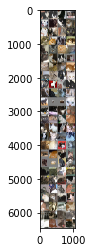

tensor([[ 1.7859e+00, -2.2618e+00],
        [ 4.6565e-01, -6.6406e-01],
        [-6.1682e-01,  4.8149e-01],
        [ 2.0648e+00, -2.5922e+00],
        [-3.5608e-01,  2.5572e-01],
        [ 1.4791e+00, -1.9318e+00],
        [-1.1769e+00,  1.2089e+00],
        [ 7.4168e-01, -9.2563e-01],
        [ 6.7833e-01, -8.5803e-01],
        [-2.7327e-01,  2.9815e-01],
        [ 3.0503e-01, -4.9297e-01],
        [ 5.9516e-01, -8.7306e-01],
        [-4.8504e-01,  4.2641e-01],
        [ 1.1026e+00, -1.2785e+00],
        [-6.5026e-01,  6.2656e-01],
        [ 1.4108e-01, -2.6897e-01],
        [ 5.5529e-01, -6.7678e-01],
        [ 4.4353e-01, -5.0945e-01],
        [-4.1618e-02, -6.6160e-03],
        [ 6.4340e-01, -8.5030e-01],
        [ 7.3854e-01, -9.3341e-01],
        [ 1.8697e-01, -2.0578e-01],
        [ 5.9078e-01, -8.2009e-01],
        [ 1.1936e+00, -1.5107e+00],
        [ 3.7167e-01, -4.6566e-01],
        [ 9.9779e-02, -1.2312e-01],
        [ 7.4819e-01, -9.3879e-01],
        [-1.1530e-01,  6.188

In [14]:
with torch.no_grad():
    dataiter = iter(test_loader)
    images, labels = dataiter.next()
    imshow(utils.make_grid(images, nrow=4))
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    print(outputs)
    print(labels)
    _, predicted = torch.max(outputs, 1)
    print(predicted)


In [17]:
# train model with standard epoch loop
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(train_loader):
        labels = labels.to(device)
        images = images.to(device)
        
        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 5 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, n_total_steps, loss.item()))

Epoch [1/25], Step [5/10], Loss: 0.2683
Epoch [1/25], Step [10/10], Loss: 0.1773
Epoch [2/25], Step [5/10], Loss: 0.1539
Epoch [2/25], Step [10/10], Loss: 0.1661
Epoch [3/25], Step [5/10], Loss: 0.0757
Epoch [3/25], Step [10/10], Loss: 0.0787
Epoch [4/25], Step [5/10], Loss: 0.0441
Epoch [4/25], Step [10/10], Loss: 0.0107
Epoch [5/25], Step [5/10], Loss: 0.0030
Epoch [5/25], Step [10/10], Loss: 0.0037
Epoch [6/25], Step [5/10], Loss: 0.0023
Epoch [6/25], Step [10/10], Loss: 0.0022
Epoch [7/25], Step [5/10], Loss: 0.0007
Epoch [7/25], Step [10/10], Loss: 0.0005
Epoch [8/25], Step [5/10], Loss: 0.0002
Epoch [8/25], Step [10/10], Loss: 0.0003
Epoch [9/25], Step [5/10], Loss: 0.0003
Epoch [9/25], Step [10/10], Loss: 0.0001
Epoch [10/25], Step [5/10], Loss: 0.0001
Epoch [10/25], Step [10/10], Loss: 0.0000
Epoch [11/25], Step [5/10], Loss: 0.0001
Epoch [11/25], Step [10/10], Loss: 0.0001
Epoch [12/25], Step [5/10], Loss: 0.0001
Epoch [12/25], Step [10/10], Loss: 0.0000
Epoch [13/25], Step [5

In [21]:
#test model
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(len(label_dir))]
    n_class_samples = [0 for i in range(len(label_dir))]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        for i in range(len(labels)):
            label = labels[i]
            n_class_samples[label] += 1
            n_class_correct[label] += (predicted[i] == label).item()
    
    acc = 100.0 * n_correct / n_samples
    print('Accuracy of the network: %d %%' % acc)
    for i in range(len(label_dir)):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print('Accuracy of %5s : %2d %%' % (idx_to_class[i], acc))

Accuracy of the network: 64 %
Accuracy of  cats : 66 %
Accuracy of  dogs : 62 %
